# Automated CCR task generation

**Functionality provided to-date:**
- Generate causal DAG.
- Generate its corresponding CCT.
- Randomly generate human names for nodes.
- Enumerate quantities of interest for CCR evaluation: global, local, and compositions.
- Generate text prompts corresponding to the generated SCM and chosen theme (factual, counterfactual). 
- Sample data from the SCM (observational, interventional).
- Compute PNS, PN, PS, ATE from interventional data samples.

**Prompt themes:**
- CandyParty.
- Football.
- Flower Gardening.
- Vaccination.

**Sources of variation in the SCM:**
- Total biconnected components in the causal DAG.
- Nodes per biconnected component.
- Graph type of biconnected component (cycle or wheel graph).
- Parameter to Bernoulli distributions chosen uniformly at random or fixed.
- Causal function (logical or, logical and; logical or is currently more reliable).

## Preamble

In [1]:
# General importations.
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import platform
import time
import warnings
import math
import string
from random import shuffle, seed
from faker.providers.person.en import Provider
import networkx as nx
import itertools

from task_generation import TaskGenerator, Utils

# View versioning.
print("python version     :", platform.python_version())
print("numpy version      :", np.__version__)
print("pandas version     :", pd.__version__)
print("matplotlib version :", matplotlib.__version__)
print("seaborn version    :", sns.__version__)
print("networkx version    :", nx.__version__)

python version     : 3.10.13
numpy version      : 1.26.3
pandas version     : 2.1.4
matplotlib version : 3.8.0
seaborn version    : 0.12.2
networkx version    : 3.4.2


In [2]:
#!pip freeze > requirements.txt

In [3]:
u = Utils()

# Automated design

## CandyParty

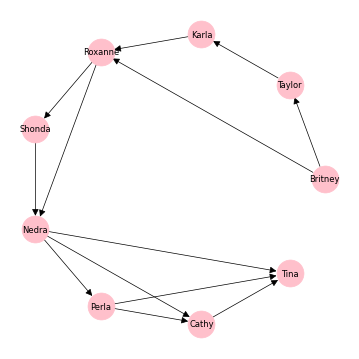


-- Context prompt --
A group of friends is going to a party where candies will be randomly distributed. Britney will be happy if she gets at least 3 candies. Taylor will be happy if she gets at least 3 candies or if Britney is happy. Karla will be happy if she gets at least 2 candies or if Taylor is happy. Roxanne will be happy if she gets at least 3 candies or if Britney is happy or if Karla is happy. Shonda will be happy if she gets at least 5 candies or if Roxanne is happy. Nedra will be happy if she gets at least 3 candies or if Roxanne is happy or if Shonda is happy. Perla will be happy if she gets at least 4 candies or if Nedra is happy. Cathy will be happy if she gets at least 3 candies or if Nedra is happy or if Perla is happy. Tina will be happy if she gets at least 2 candies or if Nedra is happy or if Perla is happy or if Cathy is happy.  After distributing the candies, Britney gets 2 candies, Taylor gets 2 candies, Karla gets 6 candies, Roxanne gets 4 candies, Shonda gets 7

Britney  Taylor  Karla  Roxanne  Shonda  Nedra  Perla  Cathy  Tina  \
0        0       0      0        0       1      1      1      1     1   
1        1       1      1        1       1      1      1      1     1   
2        0       0      1        1       1      1      1      1     1   
3        0       0      0        1       1      1      1      1     1   
4        0       1      1        1       1      1      1      1     1   

   Britney_do_Britney_0  ...  Tina_do_Britney_0  Britney_do_Britney_1  \
0                     0  ...                  1                     1   
1                     0  ...                  1                     1   
2                     0  ...                  1                     1   
3                     0  ...                  1                     1   
4                     0  ...                  1                     1   

   Taylor_do_Britney_1  Karla_do_Britney_1  Roxanne_do_Britney_1  \
0                    1                   1                     1   
1                    1                   1                     1   
2                    1                   1                     1   
3                    1                   1                     1   
4                    1                   1                     1   

   Shonda_do_Britney_1  Nedra_do_Britney_1  Perla_do_Britney_1  \
0                    1                   1                   1   
1                    1                   1                   1   
2                    1                   1                   1   
3                    1                   1                   1   
4                    1                   1                   1   

   Cathy_do_Britney_1  Tina_do_Britney_1  
0                   1                  1  
1                   1                  1  
2                   1                  1  
3                   1                  1  
4                   1                  1  

[5 rows x 27 columns]

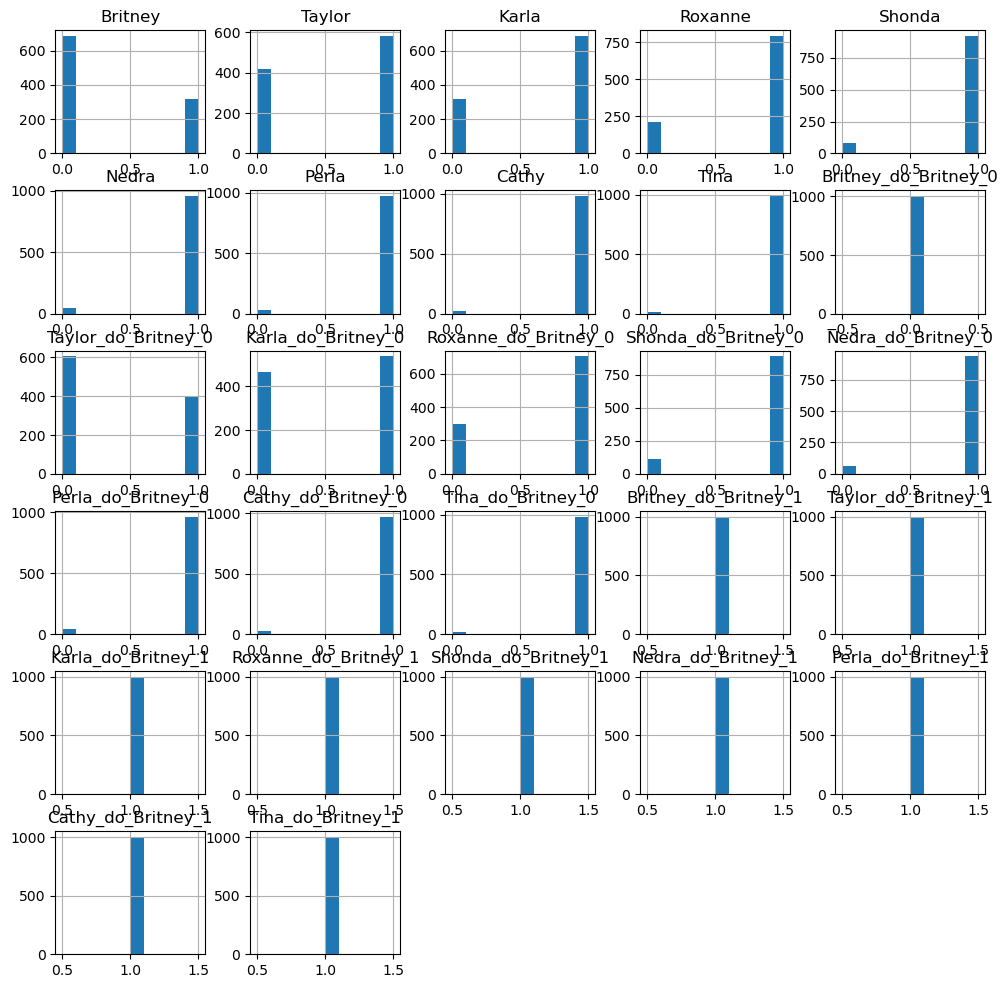


-- Get probabilities of causation from interventional data --
{'PN': 0.006329113924050633, 'PS': 1.0, 'PNS': 0.017}
ATE =  0.017000000000000015


In [7]:
# Instantiate task.
tg = TaskGenerator(n_per_bcc = [4,3,4], 
                   bcc_types = ["cycle", "cycle", "wheel"], 
                   label_as = "names",
                   bern = "random")

print("\n-- Context prompt --")
print(tg.generate_context_prompt(theme = "candy", 
                                 conjunction = "or"))

print("\n-- Factual prompt --")
print(tg.generate_factual_prompt(theme = "candy",
                                 effect_node = tg.nodes[-1]))

print("\n-- Ground truth booleans given factual prompt --")
print(tg.get_ground_truth())

print("\n-- Counterfactual prompts --")
print(tg.generate_counterfactual_prompt(theme = "candy",
                                        effect_node = tg.nodes[-1],
                                        intervene_node = tg.nodes[0],
                                        intervene_value = 1))
print(tg.generate_counterfactual_prompt(theme = "candy",
                                        effect_node = tg.nodes[-1],
                                        intervene_node = tg.nodes[0],
                                        intervene_value = 0))

print("\n-- Quantities of interest by cause-effect pair --")
print("Global:", tg.get_global())
print("Local:", tg.get_local())
print("Compositions:", tg.get_compositions())

print("\n-- Sample from SCM (observational and interventional) --")
n = 1000
cause = tg.nodes[0] # root of DAG
effect = tg.nodes[-1] # leaf of DAG
df_obs = tg.sample_scm(n = n)
df_x0 = tg.sample_scm(n = n, intervene_node = cause, intervene_value = 0)
df_x0.columns = [x + "_do_{}_0".format(cause) for x in df_x0.columns]
df_x1 = tg.sample_scm(n = n, intervene_node = cause, intervene_value = 1)
df_x1.columns = [x + "_do_{}_1".format(cause) for x in df_x1.columns]
df = pd.concat((df_obs, df_x0, df_x1), axis = 1)
display(df.head())
_ = df.hist(figsize = (12,12))
plt.show()

print("\n-- Get probabilities of causation from interventional data --")
print(u.get_prc_direct(df, 
                       x = cause, 
                       y = effect, 
                       y_do_x0 = effect+"_do_{}_0".format(cause), 
                       y_do_x1 = effect+"_do_{}_1".format(cause)))

print("ATE = ", u.get_ate(df_do_1 = df_x1, 
                          df_do_0 = df_x0,
                          effect_do_1 = effect+"_do_{}_1".format(cause),
                          effect_do_0 = effect+"_do_{}_0".format(cause)))

## Vaccination

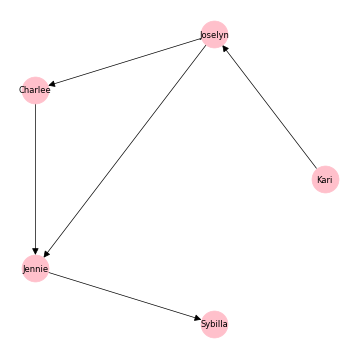


-- Context prompt --
A group of friends is considering whether or not to get vaccinated against the flu this year. Kari will get vaccinated if she was sick for at least 3 days in the previous flu season. Joselyn will get vaccinated if she was sick for at least 2 days in the previous flu season or if Kari gets vaccinated. Charlee will get vaccinated if she was sick for at least 4 days in the previous flu season or if Joselyn gets vaccinated. Jennie will get vaccinated if she was sick for at least 4 days in the previous flu season or if Joselyn gets vaccinated or if Charlee gets vaccinated. Sybilla will get vaccinated if she was sick for at least 4 days in the previous flu season or if Jennie gets vaccinated.  During the previous flu season, Kari was sick for 2 days, Joselyn was sick for 7 days, Charlee was sick for 2 days, Jennie was sick for 6 days, and Sybilla was sick for 6 days.

-- Factual prompt --
Did Sybilla get vaccinated? Be as concise as possible.

-- Ground truth booleans g

Kari  Joselyn  Charlee  Jennie  Sybilla  Kari_do_Kari_0  Joselyn_do_Kari_0  \
0     0        0        0       0        0               0                  0   
1     1        1        1       1        1               0                  0   
2     0        0        1       1        1               0                  0   
3     0        0        0       1        1               0                  0   
4     0        1        1       1        1               0                  1   

   Charlee_do_Kari_0  Jennie_do_Kari_0  Sybilla_do_Kari_0  Kari_do_Kari_1  \
0                  0                 0                  0               1   
1                  0                 1                  1               1   
2                  1                 1                  1               1   
3                  0                 1                  1               1   
4                  1                 1                  1               1   

   Joselyn_do_Kari_1  Charlee_do_Kari_1  Jennie_do_Kari_1  Sybilla_do_Kari_1  
0                  1                  1                 1                  1  
1                  1                  1                 1                  1  
2                  1                  1                 1                  1  
3                  1                  1                 1                  1  
4                  1                  1                 1                  1

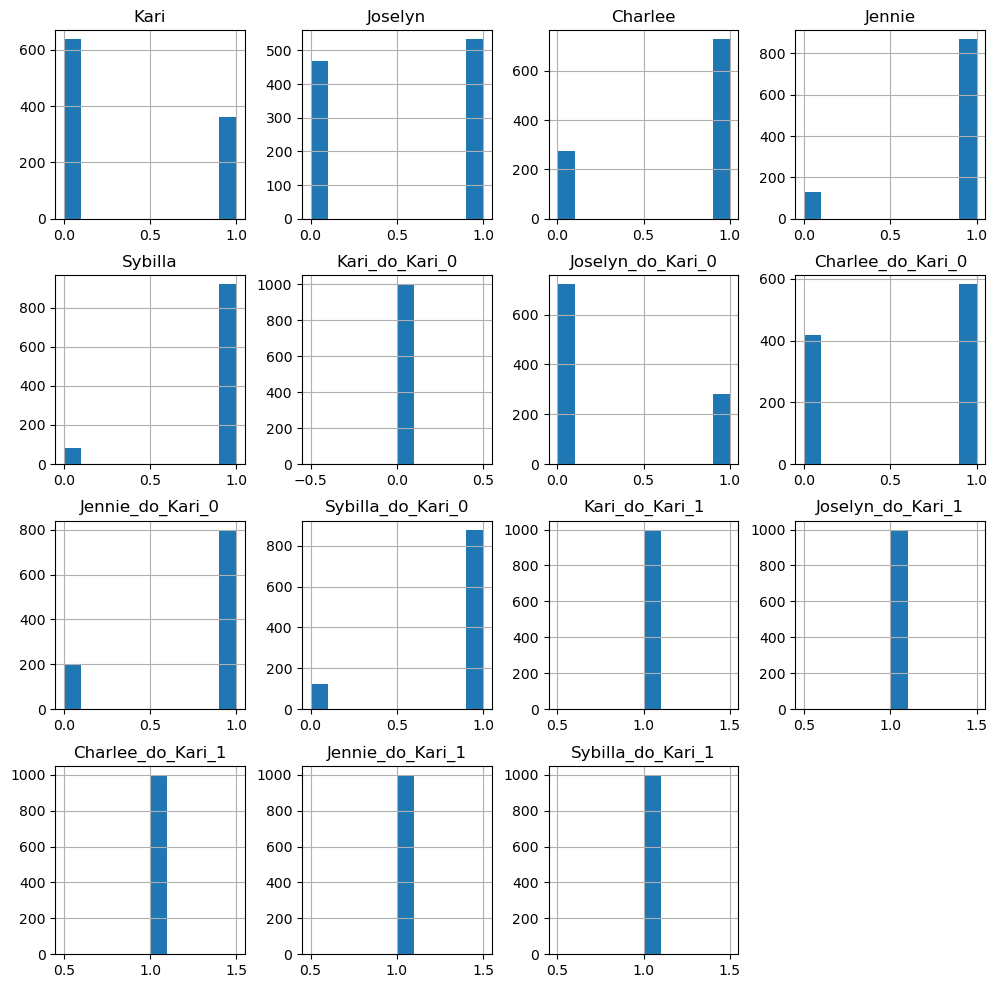


-- Get probabilities of causation from interventional data --
{'PN': 0.11019283746556474, 'PS': 1.0, 'PNS': 0.121}
ATE =  0.121


In [17]:
# Instantiate task.
theme = "vaccine"
conjunction = "or"
tg = TaskGenerator(n_per_bcc = [2,3,2], 
                   bcc_types = ["cycle"]*3, 
                   label_as = "names",
                   bern = "random")

print("\n-- Context prompt --")
print(tg.generate_context_prompt(theme = theme, 
                                 conjunction = conjunction))

print("\n-- Factual prompt --")
print(tg.generate_factual_prompt(theme = theme,
                                 effect_node = tg.nodes[-1]))

print("\n-- Ground truth booleans given factual prompt --")
print(tg.get_ground_truth())

print("\n-- Counterfactual prompts --")
print(tg.generate_counterfactual_prompt(theme = theme,
                                        effect_node = tg.nodes[-1],
                                        intervene_node = tg.nodes[0],
                                        intervene_value = 1))
print(tg.generate_counterfactual_prompt(theme = theme,
                                        effect_node = tg.nodes[-1],
                                        intervene_node = tg.nodes[0],
                                        intervene_value = 0))

print("\n-- Quantities of interest by cause-effect pair --")
print("Global:", tg.get_global())
print("Local:", tg.get_local())
print("Compositions:", tg.get_compositions())

print("\n-- Sample from SCM (observational and interventional) --")
n = 1000
cause = tg.nodes[0] # root of DAG
effect = tg.nodes[-1] # leaf of DAG
df_obs = tg.sample_scm(n = n)
df_x0 = tg.sample_scm(n = n, intervene_node = cause, intervene_value = 0)
df_x0.columns = [x + "_do_{}_0".format(cause) for x in df_x0.columns]
df_x1 = tg.sample_scm(n = n, intervene_node = cause, intervene_value = 1)
df_x1.columns = [x + "_do_{}_1".format(cause) for x in df_x1.columns]
df = pd.concat((df_obs, df_x0, df_x1), axis = 1)
display(df.head())
_ = df.hist(figsize = (12,12))
plt.show()

print("\n-- Get probabilities of causation from interventional data --")
print(u.get_prc_direct(df, 
                       x = cause, 
                       y = effect, 
                       y_do_x0 = effect+"_do_{}_0".format(cause), 
                       y_do_x1 = effect+"_do_{}_1".format(cause)))

print("ATE = ", u.get_ate(df_do_1 = df_x1, 
                          df_do_0 = df_x0,
                          effect_do_1 = effect+"_do_{}_1".format(cause),
                          effect_do_0 = effect+"_do_{}_0".format(cause)))

## Flower Gardening

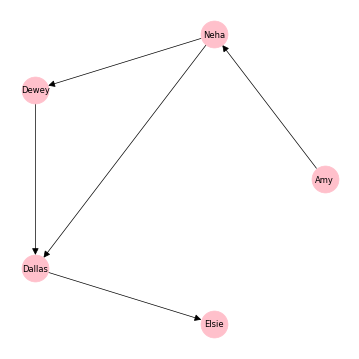


-- Context prompt --
A group of friends is planting a bed of flowers from seed, but the seed packets are not labeled. Amy will be happy if the flowers she planted are pink. Neha will be happy if the flowers she planted are purple or if Amy is happy. Dewey will be happy if the flowers she planted are yellow or if Neha is happy. Dallas will be happy if the flowers she planted are red or if Neha is happy or if Dewey is happy. Elsie will be happy if the flowers she planted are pink or if Dallas is happy.  Once the flowers bloom, Amy's flowers are deep purple, Neha's flowers are blood red, Dewey's flowers are amethyst purple, Dallas's flowers are lemon yellow, and Elsie's flowers are amethyst purple.

-- Factual prompt --
Is Elsie happy? Be as concise as possible.

-- Ground truth booleans given factual prompt --
[False, False, False, False, False]

-- Counterfactual prompts --
Now, suppose that Amy is happy, regardless of her other circumstances. With this assumption, is Elsie happy? Be a

Amy  Neha  Dewey  Dallas  Elsie  Amy_do_Amy_0  Neha_do_Amy_0  \
0    0     0      0       0      0             0              0   
1    0     0      0       0      1             0              0   
2    0     0      1       1      1             0              0   
3    0     0      0       0      1             0              0   
4    0     1      1       1      1             0              1   

   Dewey_do_Amy_0  Dallas_do_Amy_0  Elsie_do_Amy_0  Amy_do_Amy_1  \
0               0                0               0             1   
1               0                0               1             1   
2               1                1               1             1   
3               0                0               1             1   
4               1                1               1             1   

   Neha_do_Amy_1  Dewey_do_Amy_1  Dallas_do_Amy_1  Elsie_do_Amy_1  
0              1               1                1               1  
1              1               1                1               1  
2              1               1                1               1  
3              1               1                1               1  
4              1               1                1               1

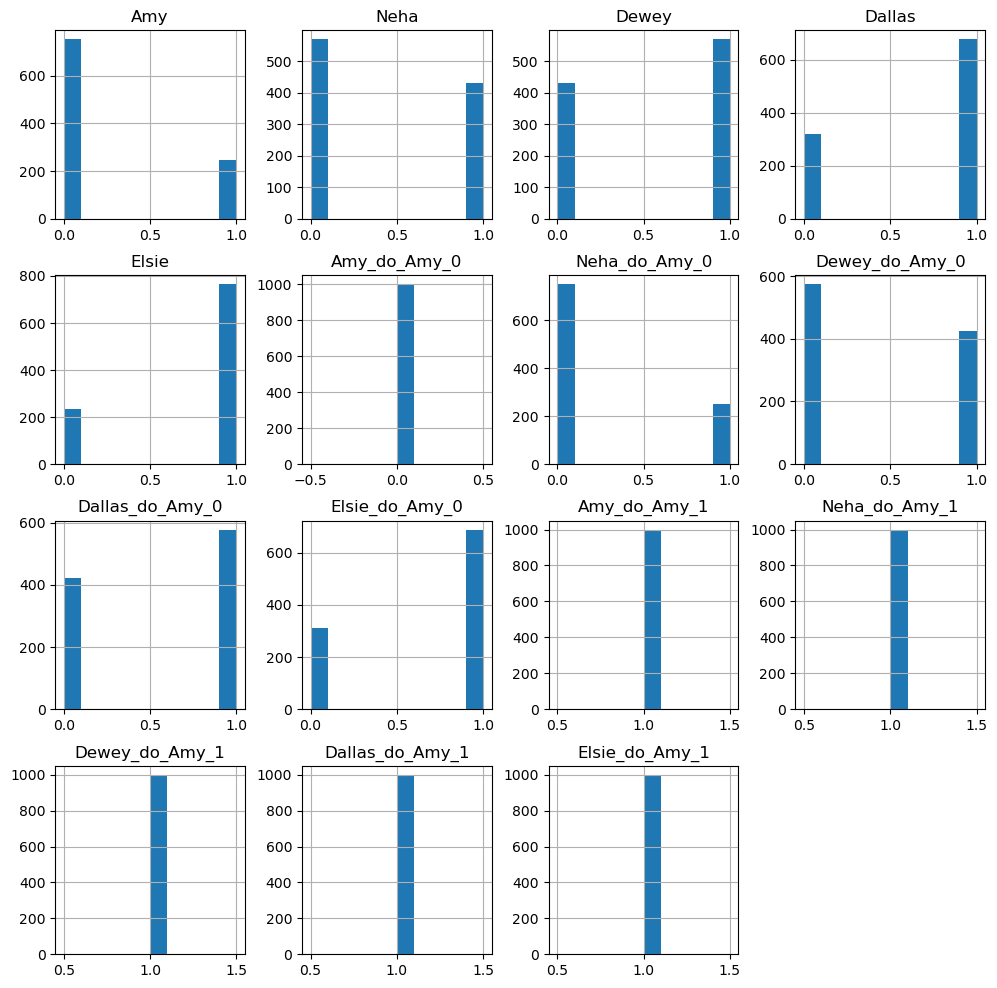


-- Get probabilities of causation from interventional data --
{'PN': 0.30364372469635625, 'PS': 1.0, 'PNS': 0.311}
ATE =  0.31100000000000005


In [4]:
# Instantiate task.
theme = "flowers"
conjunction = "or"
tg = TaskGenerator(n_per_bcc = [2,3,2], 
                   bcc_types = ["cycle"]*3, 
                   label_as = "names",
                   bern = "random")

print("\n-- Context prompt --")
print(tg.generate_context_prompt(theme = theme, 
                                 conjunction = conjunction))

print("\n-- Factual prompt --")
print(tg.generate_factual_prompt(theme = theme,
                                 effect_node = tg.nodes[-1]))

print("\n-- Ground truth booleans given factual prompt --")
print(tg.get_ground_truth(qualitative = True))

print("\n-- Counterfactual prompts --")
print(tg.generate_counterfactual_prompt(theme = theme,
                                        effect_node = tg.nodes[-1],
                                        intervene_node = tg.nodes[0],
                                        intervene_value = 1))
print(tg.generate_counterfactual_prompt(theme = theme,
                                        effect_node = tg.nodes[-1],
                                        intervene_node = tg.nodes[0],
                                        intervene_value = 0))

print("\n-- Quantities of interest by cause-effect pair --")
print("Global:", tg.get_global())
print("Local:", tg.get_local())
print("Compositions:", tg.get_compositions())

print("\n-- Sample from SCM (observational and interventional) --")
n = 1000
cause = tg.nodes[0] # root of DAG
effect = tg.nodes[-1] # leaf of DAG
df_obs = tg.sample_scm(n = n, qualitative = True)
df_x0 = tg.sample_scm(n = n, intervene_node = cause, intervene_value = 0, qualitative = True)
df_x0.columns = [x + "_do_{}_0".format(cause) for x in df_x0.columns]
df_x1 = tg.sample_scm(n = n, intervene_node = cause, intervene_value = 1, qualitative = True)
df_x1.columns = [x + "_do_{}_1".format(cause) for x in df_x1.columns]
df = pd.concat((df_obs, df_x0, df_x1), axis = 1)
display(df.head())
_ = df.hist(figsize = (12,12))
plt.show()

print("\n-- Get probabilities of causation from interventional data --")
print(u.get_prc_direct(df, 
                       x = cause, 
                       y = effect, 
                       y_do_x0 = effect+"_do_{}_0".format(cause), 
                       y_do_x1 = effect+"_do_{}_1".format(cause)))

print("ATE = ", u.get_ate(df_do_1 = df_x1, 
                          df_do_0 = df_x0,
                          effect_do_1 = effect+"_do_{}_1".format(cause),
                          effect_do_0 = effect+"_do_{}_0".format(cause)))

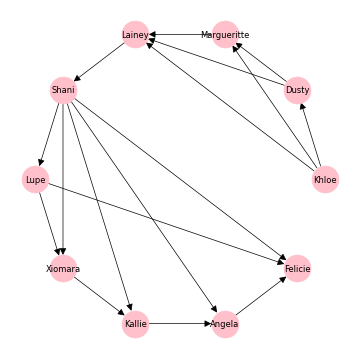


-- Context prompt --
A group of friends is planting a bed of flowers from seed, but the seed packets are not labeled. Khloe will be happy if the flowers she planted are pink. Dusty will be happy if the flowers she planted are yellow or if Khloe is happy. Margueritte will be happy if the flowers she planted are red or if Khloe is happy or if Dusty is happy. Lainey will be happy if the flowers she planted are red or if Khloe is happy or if Dusty is happy or if Margueritte is happy. Shani will be happy if the flowers she planted are pink or if Lainey is happy. Lupe will be happy if the flowers she planted are red or if Shani is happy. Xiomara will be happy if the flowers she planted are purple or if Shani is happy or if Lupe is happy. Kallie will be happy if the flowers she planted are pink or if Shani is happy or if Xiomara is happy. Angela will be happy if the flowers she planted are yellow or if Shani is happy or if Kallie is happy. Felicie will be happy if the flowers she planted are

Khloe  Dusty  Margueritte  Lainey  Shani  Lupe  Xiomara  Kallie  Angela  \
0      0      0            0       0      0     0        1       1       1   
1      0      0            0       0      1     1        1       1       1   
2      0      0            1       1      1     1        1       1       1   
3      0      0            0       0      1     1        1       1       1   
4      0      1            1       1      1     1        1       1       1   

   Felicie  ...  Khloe_do_Khloe_1  Dusty_do_Khloe_1  Margueritte_do_Khloe_1  \
0        1  ...                 1                 1                       1   
1        1  ...                 1                 1                       1   
2        1  ...                 1                 1                       1   
3        1  ...                 1                 1                       1   
4        1  ...                 1                 1                       1   

   Lainey_do_Khloe_1  Shani_do_Khloe_1  Lupe_do_Khloe_1  Xiomara_do_Khloe_1  \
0                  1                 1                1                   1   
1                  1                 1                1                   1   
2                  1                 1                1                   1   
3                  1                 1                1                   1   
4                  1                 1                1                   1   

   Kallie_do_Khloe_1  Angela_do_Khloe_1  Felicie_do_Khloe_1  
0                  1                  1                   1  
1                  1                  1                   1  
2                  1                  1                   1  
3                  1                  1                   1  
4                  1                  1                   1  

[5 rows x 30 columns]

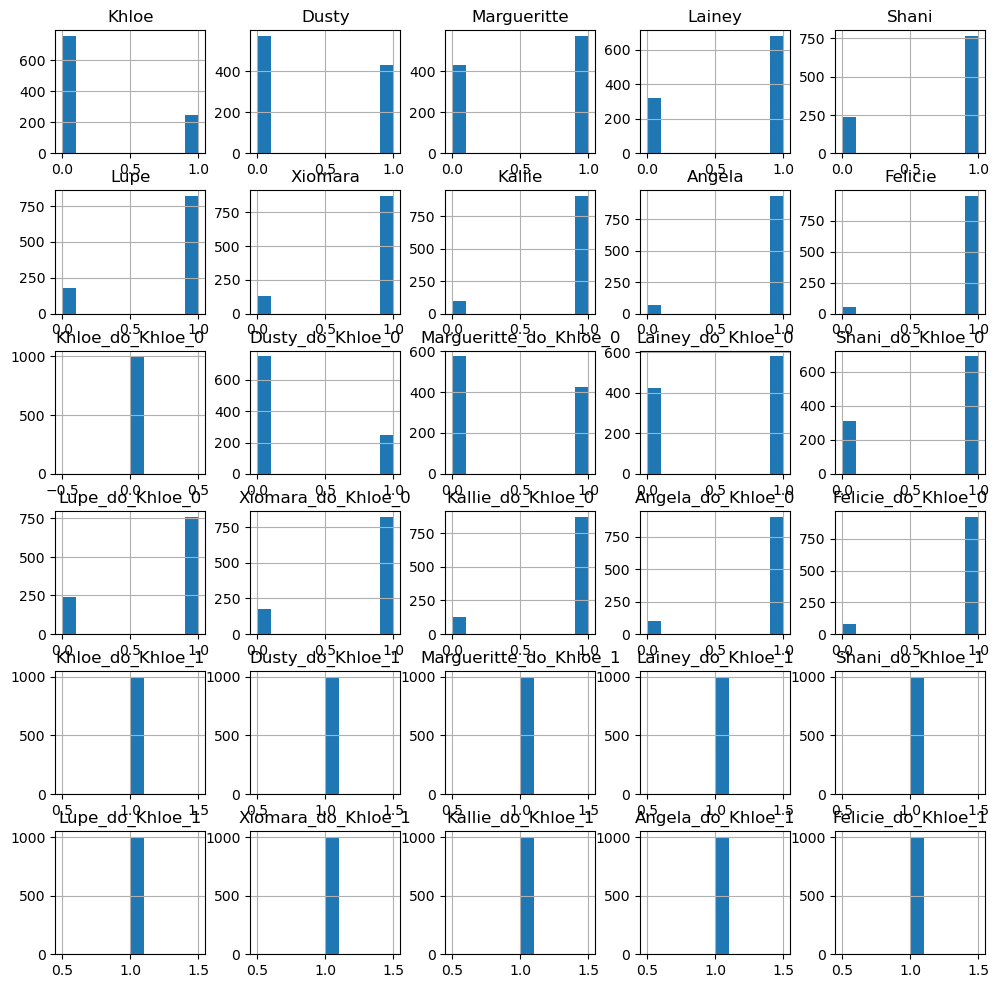


-- Get probabilities of causation from interventional data --
{'PN': 0.0931174089068826, 'PS': 1.0, 'PNS': 0.075}
ATE =  0.07499999999999996


In [6]:
# Instantiate task.
theme = "flowers"
conjunction = "or"
tg = TaskGenerator(n_per_bcc = [4,2,6], 
                   bcc_types = ["wheel"]*3, 
                   label_as = "names",
                   bern = "random")

print("\n-- Context prompt --")
print(tg.generate_context_prompt(theme = theme, 
                                 conjunction = conjunction))

print("\n-- Factual prompt --")
print(tg.generate_factual_prompt(theme = theme,
                                 effect_node = tg.nodes[-1]))

print("\n-- Ground truth booleans given factual prompt --")
print(tg.get_ground_truth(qualitative = True))

print("\n-- Counterfactual prompts --")
print(tg.generate_counterfactual_prompt(theme = theme,
                                        effect_node = tg.nodes[-1],
                                        intervene_node = tg.nodes[0],
                                        intervene_value = 1))
print(tg.generate_counterfactual_prompt(theme = theme,
                                        effect_node = tg.nodes[-1],
                                        intervene_node = tg.nodes[0],
                                        intervene_value = 0))

print("\n-- Quantities of interest by cause-effect pair --")
print("Global:", tg.get_global())
print("Local:", tg.get_local())
print("Compositions:", tg.get_compositions())

print("\n-- Sample from SCM (observational and interventional) --")
n = 1000
cause = tg.nodes[0] # root of DAG
effect = tg.nodes[-1] # leaf of DAG
df_obs = tg.sample_scm(n = n, qualitative = True)
df_x0 = tg.sample_scm(n = n, intervene_node = cause, intervene_value = 0, qualitative = True)
df_x0.columns = [x + "_do_{}_0".format(cause) for x in df_x0.columns]
df_x1 = tg.sample_scm(n = n, intervene_node = cause, intervene_value = 1, qualitative = True)
df_x1.columns = [x + "_do_{}_1".format(cause) for x in df_x1.columns]
df = pd.concat((df_obs, df_x0, df_x1), axis = 1)
display(df.head())
_ = df.hist(figsize = (12,12))
plt.show()

print("\n-- Get probabilities of causation from interventional data --")
print(u.get_prc_direct(df, 
                       x = cause, 
                       y = effect, 
                       y_do_x0 = effect+"_do_{}_0".format(cause), 
                       y_do_x1 = effect+"_do_{}_1".format(cause)))

print("ATE = ", u.get_ate(df_do_1 = df_x1, 
                          df_do_0 = df_x0,
                          effect_do_1 = effect+"_do_{}_1".format(cause),
                          effect_do_0 = effect+"_do_{}_0".format(cause)))

## Football

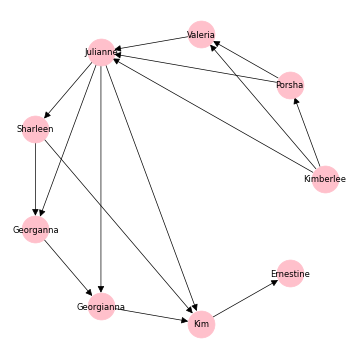


-- Context prompt --
A group of friends is considering whether or not to attend an upcoming football game. Kimberlee will go to the football game if she has been fewer than 3 times this season. Porsha will go to the football game if she has been fewer than 3 times this season or if Kimberlee goes to the game. Valeria will go to the football game if she has been fewer than 3 times this season or if Kimberlee goes to the game or if Porsha goes to the game. Julianne will go to the football game if she has been fewer than 3 times this season or if Kimberlee goes to the game or if Porsha goes to the game or if Valeria goes to the game. Sharleen will go to the football game if she has been fewer than 3 times this season or if Julianne goes to the game. Georganna will go to the football game if she has been fewer than 3 times this season or if Julianne goes to the game or if Sharleen goes to the game. Georgianna will go to the football game if she has been fewer than 3 times this season or i

Kimberlee  Porsha  Valeria  Julianne  Sharleen  Georganna  Georgianna  Kim  \
0          0       0        0         0         0          0           1    1   
1          0       0        0         0         1          1           1    1   
2          0       0        1         1         1          1           1    1   
3          0       0        0         0         1          1           1    1   
4          0       1        1         1         1          1           1    1   

   Ernestine  Kimberlee_do_Kimberlee_0  ...  Ernestine_do_Kimberlee_0  \
0          1                         0  ...                         1   
1          1                         0  ...                         1   
2          1                         0  ...                         1   
3          1                         0  ...                         1   
4          1                         0  ...                         1   

   Kimberlee_do_Kimberlee_1  Porsha_do_Kimberlee_1  Valeria_do_Kimberlee_1  \
0                         1                      1                       1   
1                         1                      1                       1   
2                         1                      1                       1   
3                         1                      1                       1   
4                         1                      1                       1   

   Julianne_do_Kimberlee_1  Sharleen_do_Kimberlee_1  Georganna_do_Kimberlee_1  \
0                        1                        1                         1   
1                        1                        1                         1   
2                        1                        1                         1   
3                        1                        1                         1   
4                        1                        1                         1   

   Georgianna_do_Kimberlee_1  Kim_do_Kimberlee_1  Ernestine_do_Kimberlee_1  
0                          1                   1                         1  
1                          1                   1                         1  
2                          1                   1                         1  
3                          1                   1                         1  
4                          1                   1                         1  

[5 rows x 27 columns]

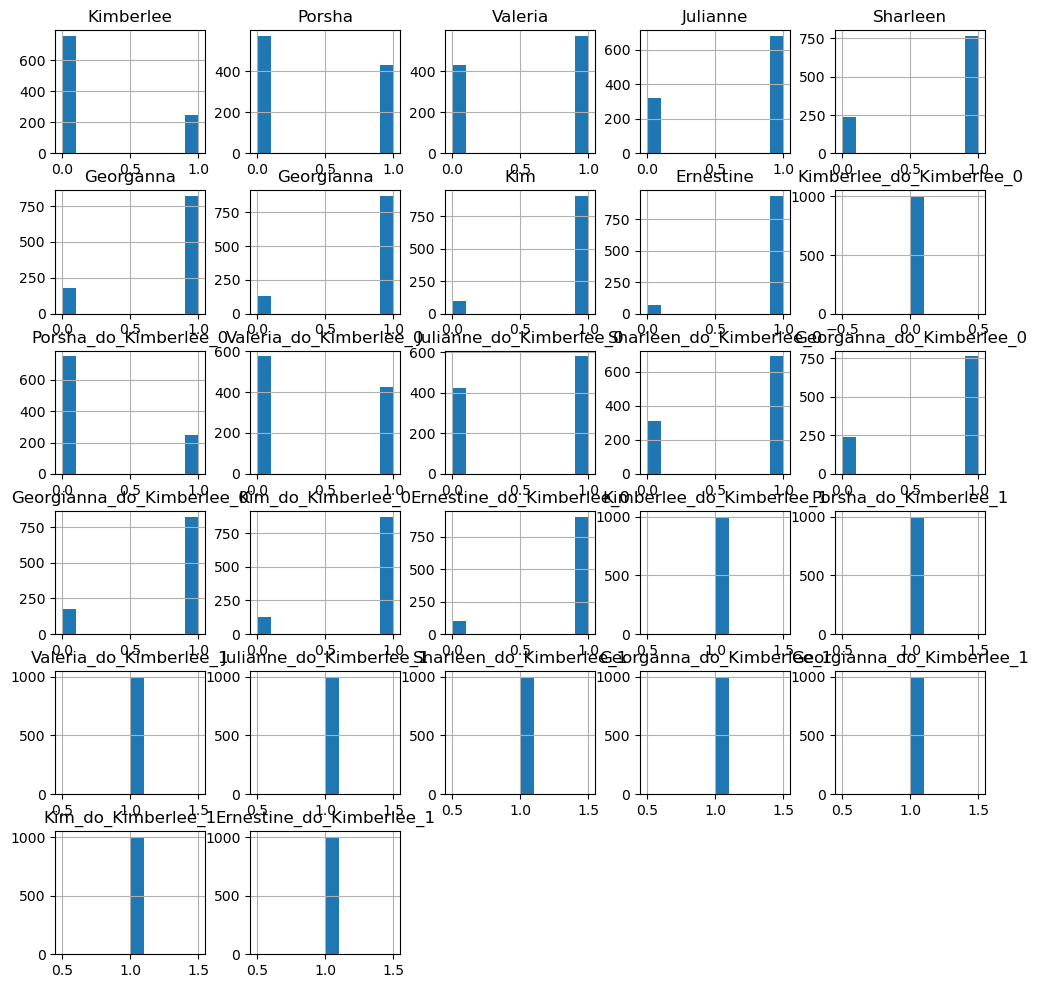


-- Get probabilities of causation from interventional data --
{'PN': 0.10526315789473684, 'PS': 1.0, 'PNS': 0.096}
ATE =  0.09599999999999997


In [13]:
# Instantiate task.
theme = "football"
conjunction = "or"
n_per_bcc = [1,4,5,2,1]
tg = TaskGenerator(n_per_bcc = n_per_bcc, 
                   bcc_types = ["wheel"]*len(n_per_bcc), 
                   label_as = "names",
                   bern = "uniform",
                   p = 0.3)

print("\n-- Context prompt --")
print(tg.generate_context_prompt(theme = theme, 
                                 conjunction = conjunction))

print("\n-- Factual prompt --")
print(tg.generate_factual_prompt(theme = theme,
                                 effect_node = tg.nodes[-1]))

print("\n-- Ground truth booleans given factual prompt --")
print(tg.get_ground_truth(qualitative = True))

print("\n-- Counterfactual prompts --")
print(tg.generate_counterfactual_prompt(theme = theme,
                                        effect_node = tg.nodes[-1],
                                        intervene_node = tg.nodes[0],
                                        intervene_value = 1))
print(tg.generate_counterfactual_prompt(theme = theme,
                                        effect_node = tg.nodes[-1],
                                        intervene_node = tg.nodes[0],
                                        intervene_value = 0))

print("\n-- Quantities of interest by cause-effect pair --")
print("Global:", tg.get_global())
print("Local:", tg.get_local())
print("Compositions:", tg.get_compositions())

print("\n-- Sample from SCM (observational and interventional) --")
n = 1000
cause = tg.nodes[0] # root of DAG
effect = tg.nodes[-1] # leaf of DAG
df_obs = tg.sample_scm(n = n, qualitative = True)
df_x0 = tg.sample_scm(n = n, intervene_node = cause, intervene_value = 0, qualitative = True)
df_x0.columns = [x + "_do_{}_0".format(cause) for x in df_x0.columns]
df_x1 = tg.sample_scm(n = n, intervene_node = cause, intervene_value = 1, qualitative = True)
df_x1.columns = [x + "_do_{}_1".format(cause) for x in df_x1.columns]
df = pd.concat((df_obs, df_x0, df_x1), axis = 1)
display(df.head())
_ = df.hist(figsize = (12,12))
plt.show()

print("\n-- Get probabilities of causation from interventional data --")
print(u.get_prc_direct(df, 
                       x = cause, 
                       y = effect, 
                       y_do_x0 = effect+"_do_{}_0".format(cause), 
                       y_do_x1 = effect+"_do_{}_1".format(cause)))

print("ATE = ", u.get_ate(df_do_1 = df_x1, 
                          df_do_0 = df_x0,
                          effect_do_1 = effect+"_do_{}_1".format(cause),
                          effect_do_0 = effect+"_do_{}_0".format(cause)))

## End of document